Для Модели Mask R-CNN реализовать пайплайн визуализацию, в результате применения которого на исходном изображении будут отображены bounding box-ы и показыны границы каждого объекта. Пример представлен ниже:

> Блок с отступами


<figure>
<img src="https://pytorch.org/tutorials/_static/img/tv_tutorial/tv_image01.png" width="1000">
</figure>

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

import torch
from skimage.io import imread
from torch.utils import data
from tqdm.notebook import tqdm, trange

import numpy as np
from skimage.transform import resize

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import albumentations

from torch import nn
import pandas as pd
from matplotlib import pyplot as plt
import math

plt.ion()   # interactive mode

In [ ]:
# Add access to Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-lv3n4z3y
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-lv3n4z3y
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp310-cp310-linux_x86_64.whl size=375524 sha256=6ae4d92786faec29803666102d56fd4247102b9962afc09fce904aca4f4e43b0
  Stored in directory: /tmp/pip-ephem-wheel-cache-kwiglsqu/wheels/39/61/b4/480fbddb4d3d6bc34083e7397bc6f5d1381f79acc68e9f3511
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.7
    Uninstalling pycocotools-2.0.7:
      Successfully uninstalled pycocotools-2.0.7


# 3. Дообучение моделей instance segmentation на примере Mask R-CNN
## 3.0. Подготовительные процедуры

Установка pycocotools

Посмотрим несколько картинок из набора данных

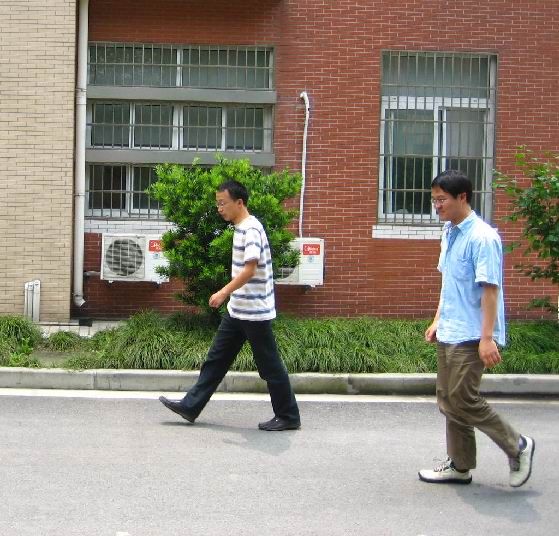

In [ ]:
from PIL import Image
Image.open('drive/MyDrive/PennFudanPed/PNGImages/FudanPed00001.png')

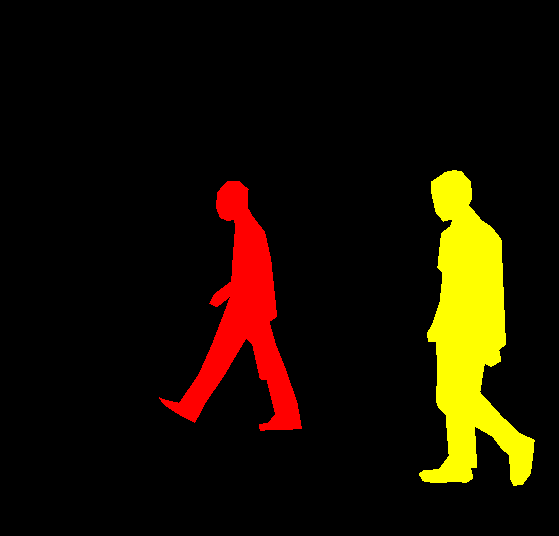

In [ ]:
mask = Image.open('drive/MyDrive/PennFudanPed/PedMasks/FudanPed00001_mask.png').convert('P')
# each mask instance has a different color, from zero to N, where
# N is the number of instances. In order to make visualization easier,
# let's adda color palette to the mask.
mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
])
mask

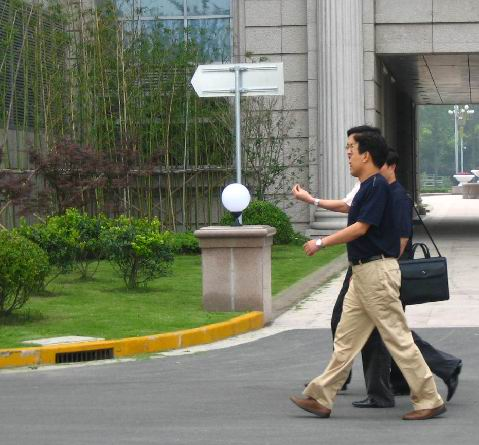

In [ ]:
Image.open('drive/MyDrive/PennFudanPed/PNGImages/FudanPed00003.png')

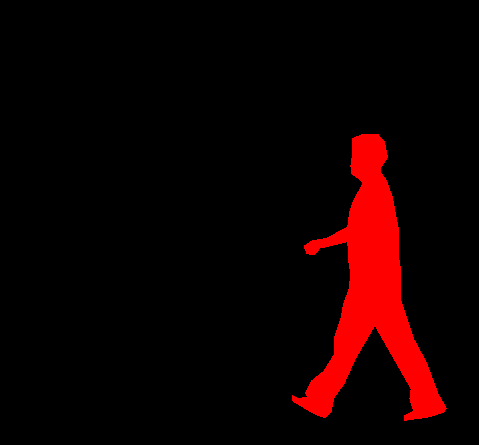

In [ ]:
mask = Image.open('drive/MyDrive/PennFudanPed/PedMasks/FudanPed00003_mask.png').convert('P')
mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
])
mask

## 3.1. Создадим класс датасета

In [ ]:
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

0

In [ ]:
import os
import numpy as np
import torch
from PIL import Image

from torchvision.transforms import v2 as T
import utils
from engine import train_one_epoch, evaluate



In [ ]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # загрузить все файлы изображений, отсортировав их по
         # убедитесь, что они выровнены
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # обратите внимание, что мы не преобразовали маску в RGB,
         # так как каждый цвет соответствует отдельному экземпляру
         # с 0 в качестве фона
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # экземпляры кодируются разными цветами
        obj_ids = np.unique(mask)
        # первый идентификатор - это фон, поэтому удалите его
        obj_ids = obj_ids[1:]

        # разбиваем маску с цветовой кодировкой на множество
         # бинарных масок
        masks = mask == obj_ids[:, None, None]

        # получаем координаты ограничивающей рамки для каждой маски
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # есть только один класс
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
dataset = PennFudanDataset('drive/MyDrive/PennFudanPed/')
dataset[0][1]

{'boxes': tensor([[159., 181., 301., 430.],
         [419., 170., 534., 485.]]),
 'labels': tensor([1, 1]),
 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
 'image_id': 0,
 'area': tensor([35358., 36225.]),
 'iscrowd': tensor([0, 0])}

## 3.2. Определим модель



Mask R-CNN берёт за основу Faster R-CNN и добавляет к ней дополнительную ветвь. Эта ветвь на выходе должна выдать маску объекта в дополнение к ограничивающему прямоугольнику и классу.

Вначале вспомним Faster R-CNN.



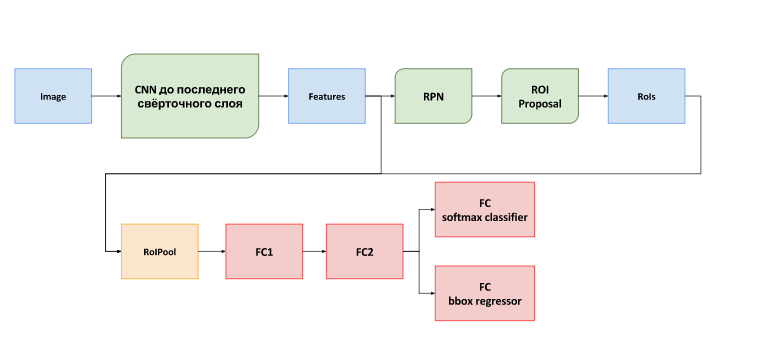

Она состоит из трёх частей:

Генератор особенностей (features extractor), который, получив на вход изображение, выдаёт 3х-мерный тензор особенностей. При этом каждому вектору особенностей из этого тензора соответствует некоторый прямоугольник исходного изображения. В качестве такого генератора может выступать, например, сеть VGG16 или ResNet101 без полносвязных слоёв.

Region Proposal Network (RPN). Сеть, которая получив на вход тензор особенностей, генерирует некоторое количество регионов, в которых предположительно есть объекты

Полносвязные слои - это сеть, которая для каждого региона, вырезает, соответствующую этому региону, часть из тензора особенностей, и выдаёт:

* класс объекта (возможно, что класс будет background)

* уточнённый прямоугольник объекта

Предлагается добавить дополнительную ветвь к полносвязным слоям, которая генерировала бы бинарную маску внутри прямоугольника объекта. Таким образом у сети появляется дополнительный выход, с него для каждого из K классов снимается бинарная маска размера m×m. Соответственно, схема сети меняется следующим образом:

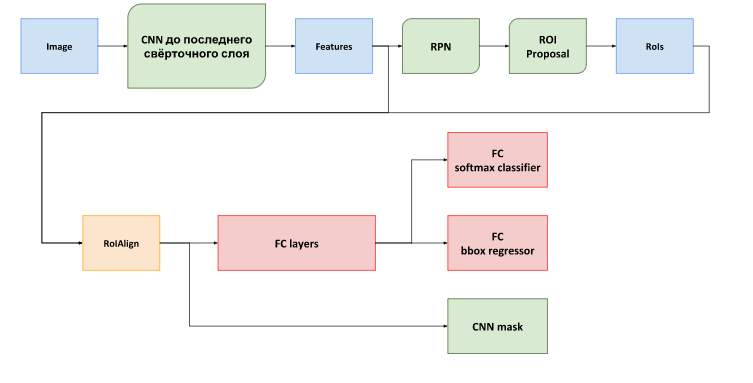

Важно сделать несколько замечаний об отличии Mask R-CNN подхода от случая сегментации изображения.

Во-первых, масок выдаётся K штук, т.е. для каждого класса своя маска, поэтому выбор правильной маски мы осуществляем в зависимости от класса, который выдала сеть. Т.е. в данном подходе разделяется предсказание класса и предсказание маски. Это существенное отличие от случая просто сегментации изображения, например, где на выходе мы имеем для каждого пикселя изображения вектор с вероятностями того, что этот пиксель принадлежит соответствующему классу. Это отличие определяет и вклад маски в функцию ошибки, если ранее это softmax и затем мультиноминальная кросс энтропия, то здесь сигмоид и бинарный штраф.

Во-вторых, сеть генерирует маску фиксированного (не зависящего от размера ROI) размера m×m.

Большая часть Faster R-CNN схемы сохранена (генератор особенностей, RPN, полносвязные слои для получения класса объекта и уточнения прмоугольника). Класс и прямоугольник объекта сеть выдаёт в виде векторов небольшой размерности (для класса это вектор вероятностей, для прямоугольника вектор свигов координат), и их логично генерировать, используя полносвязные слои. Однако, маску, которая по сути бинарное изображение, естественно генерировать, сохраняя пространственную структуру, имеющуюся в тензоре особенностей. А значит вместо полносвязных слоёв будем использовать свёрточные. Это в том числе позволит уменьшить число параметров, а значит упростит обучение.

**RoIAlign**

Еще одно изменение в структуре сети, связанное с желанием получить маску объекта, это замена RoIPool слоя на RoIAlign. В RoIPool для каждого RoI на тензор особенностей накладывалась сетка с фиксированным числом ячеек (например, 7x7) и к каждой ячейке сетки применялся MaxPooling, таким образом для каждого прямоугольника претендента получался тензор особенностей, но уже фиксированных пространственных размерностей (те самые 7x7). Проблема в том, что при извлечении особенностей для прямоугольника при помощи RoIPool процедуры, координаты прямоугольника округляются, а ячейки на которые разбит RoI выравниваются по границам особенностей. В случае когда мы хотим только получить класс объекта и его расположение на изображении, такой “не точный” подход нас вполне устраивает, поскольку данные характеристики объекта устойчивы к малым сдвигам. Однако, для получение маски это упрощение не даёт достаточной точности.

**RoIAlign**

Не округляя координаты и не выравнивая, в каждой ячейке заводим дополнительную сетку. В каждом конкретном случае используются шаблоны билинейной интерполяции, чтобы получить значение особенностей, а затем использовать MaxPool для генерации.  RoIAlign слоя улучшает качество работы сети, как относительно случая RoIPool.

Используем Mask R-CNN, основанный на Faster R-CNN. Faster R-CNN — это модель, которая предсказывает как ограничивающие рамки, так и оценки классов для потенциальных объектов на изображении.

<figure>
<img src="https://pytorch.org/tutorials/_static/img/tv_tutorial/tv_image03.png" width="1000">
</figure>

Mask R-CNN добавляет дополнительную ветвь в Faster R-CNN, которая также предсказывает маски сегментации для каждого экземпляра.

<figure>
<img src="https://pytorch.org/tutorials/_static/img/tv_tutorial/tv_image04.png" width="1000">
</figure>


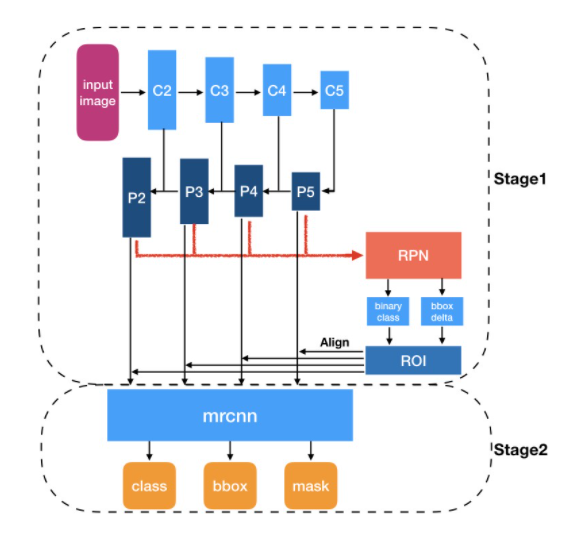

Backbone —  состоит из пути «снизу вверх», пути «сверху вниз» и боковых связей. Восходящим путем может быть любой ConvNet, обычно ResNet или VGG, который извлекает признаки из необработанных изображений. Путь «сверху вниз» создает пирамидальную карту признаков, которая по размеру аналогична пути «снизу вверх». Боковые соединения представляют собой операции свертки и добавления между двумя соответствующими уровнями двух путей.


Облегченная нейронная сеть, называемая RPN, сканирует все пути сверху вниз (далее именуемые картой объектов) и предлагает области, которые могут содержать объекты.


На втором этапе другая нейронная сеть берет предложенные на первом этапе регионы и назначает их нескольким конкретным областям уровня карты объектов, сканирует эти области и генерирует классы объектов (мультикатегориальная классификация), ограничивающие рамки и маски.

Условно разделяют разработанную архитектуру на CNN-сеть вычисления признаков изображения, называемую  backbone, и head — объединение частей, отвечающих за предсказание охватывающей рамки, классификацию объекта и определение его маски. Loss функция для них общая и включает три компонента:
$L = L_{cls} + L_{box} + L_{mask}$


Есть две распространенные ситуации, когда может потребоваться изменить одну из доступных моделей в torchvision modelzoo. Первый — когда мы хотим начать с предварительно обученной модели и просто настроить последний слой. Другой — когда мы хотим заменить основу модели другой (например, для более быстрых прогнозов).

## 3.2.1. Дообучение модели

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# загрузить предварительно обученную модель, предварительно обученную на COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 157MB/s]


## 3.2.2. Замена Backbone модели

In [ ]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator #Region Proposal Network (RPN)

# загрузить предварительно обученную модель для классификации и возврата
# только features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features

# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 125MB/s]


Воспользуемся подходом Instance сегментации на основе Mask R-CNN и применим подход дообучения модели

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # загрузить предварительно обученную модель сегментации экземпляра pre-trained на COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # получить количество входных признаков для классификатора
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

## 3.3. Воспользуемся готовыми функциями для обучения и оценки модели

In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 448936, done.
remote: Counting objects: 100% (29398/29398), done.
remote: Compressing objects: 100% (1407/1407), done.
remote: Total 448936 (delta 28018), reused 29269 (delta 27946), pack-reused 419538
Receiving objects: 100% (448936/448936), 887.25 MiB | 29.31 MiB/s, done.
Resolving deltas: 100% (417114/417114), done.
Note: switching to 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at be376084d8 version check against PyTorch's CUDA version


Напишем функцию для аугментации данных

In [ ]:
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

## 3.4. Инициализация и обучение модели

In [ ]:
# use our dataset and defined transformations
dataset = PennFudanDataset('drive/MyDrive/PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('drive/MyDrive/PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 153MB/s]


In [ ]:
# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/60]  eta: 0:05:08  lr: 0.000090  loss: 3.2517 (3.2517)  loss_classifier: 0.7470 (0.7470)  loss_box_reg: 0.1931 (0.1931)  loss_mask: 2.1749 (2.1749)  loss_objectness: 0.1175 (0.1175)  loss_rpn_box_reg: 0.0191 (0.0191)  time: 5.1372  data: 1.8493  max mem: 2177
Epoch: [0]  [10/60]  eta: 0:00:50  lr: 0.000936  loss: 1.9799 (2.1138)  loss_classifier: 0.5031 (0.4741)  loss_box_reg: 0.1931 (0.2170)  loss_mask: 1.3309 (1.3392)  loss_objectness: 0.0471 (0.0715)  loss_rpn_box_reg: 0.0106 (0.0120)  time: 1.0070  data: 0.1783  max mem: 3223
Epoch: [0]  [20/60]  eta: 0:00:31  lr: 0.001783  loss: 1.2743 (1.6891)  loss_classifier: 0.2449 (0.3387)  loss_box_reg: 0.2204 (0.2113)  loss_mask: 0.7460 (1.0713)  loss_objectness: 0.0421 (0.0574)  loss_rpn_box_reg: 0.0067 (0.0104)  time: 0.5663  data: 0.0103  max mem: 3223
Epoch: [0]  [30/60]  eta: 0:00:21  lr: 0.002629  loss: 1.0276 (1.4714)  loss_classifier: 0.1524 (0.2802)  loss_box_reg: 0.2204 (0.2107)  loss_mask: 0.5763 (0.9144)  loss_ob

In [ ]:
# save the model
torch.save(model.state_dict(), "fundan_mask_rcnn.pt")

## 3.5. Визуализация результатов работы модели

In [ ]:
# pick one image from the test set
img, _ = dataset_test[1]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

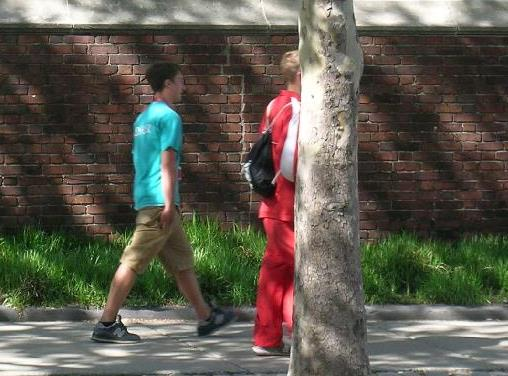

In [ ]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

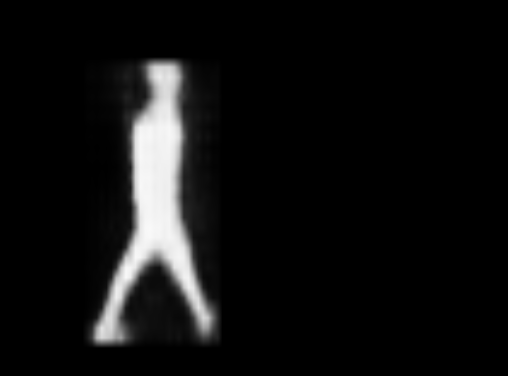

In [ ]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

In [ ]:
image, y = dataset_test[1]
image

tensor([[[0.4667, 0.4941, 0.5255,  ..., 0.6784, 0.6863, 0.6941],
         [0.4784, 0.5020, 0.5294,  ..., 0.6078, 0.6118, 0.6157],
         [0.5020, 0.5255, 0.5490,  ..., 0.5451, 0.5412, 0.5412],
         ...,
         [0.9765, 0.9686, 0.9765,  ..., 0.5216, 0.5059, 0.5373],
         [0.9608, 0.9529, 0.9608,  ..., 0.5451, 0.5373, 0.5490],
         [0.9608, 0.9529, 0.9451,  ..., 0.4314, 0.4353, 0.4078]],

        [[0.4745, 0.5020, 0.5333,  ..., 0.6902, 0.6980, 0.7059],
         [0.4863, 0.5098, 0.5373,  ..., 0.6196, 0.6235, 0.6275],
         [0.5059, 0.5294, 0.5569,  ..., 0.5569, 0.5529, 0.5529],
         ...,
         [0.9490, 0.9529, 0.9490,  ..., 0.5373, 0.5098, 0.5412],
         [0.9255, 0.9255, 0.9255,  ..., 0.5608, 0.5412, 0.5529],
         [0.9255, 0.9176, 0.9098,  ..., 0.4471, 0.4392, 0.4118]],

        [[0.4314, 0.4588, 0.4902,  ..., 0.6549, 0.6627, 0.6706],
         [0.4431, 0.4667, 0.4941,  ..., 0.5843, 0.5882, 0.5922],
         [0.4745, 0.4980, 0.5137,  ..., 0.5137, 0.5098, 0.

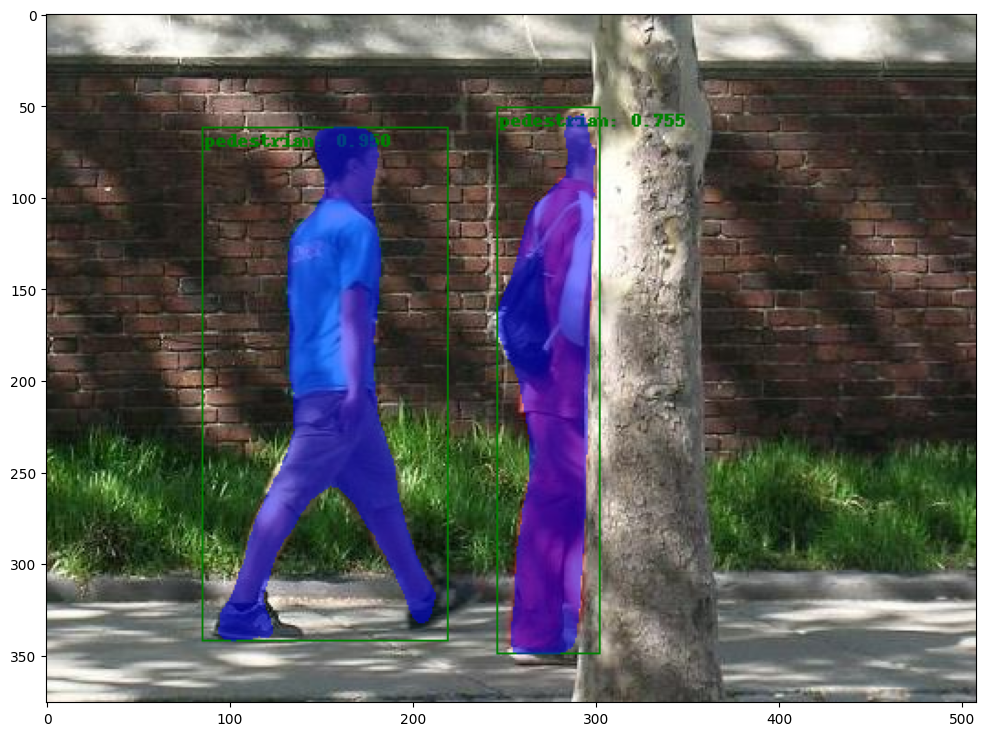

In [ ]:
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
import cv2


image, _ = dataset_test[1]
# put the model in evaluation mode
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]

labels = pred["labels"][predictions[0]['scores'] > 0.75]
scores = pred["scores"][predictions[0]['scores'] > 0.75]
boxes = pred["boxes"][predictions[0]['scores'] > 0.75]
masks = pred["masks"][predictions[0]['scores'] > 0.75]
image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(labels, scores)]
pred_boxes = boxes.long()

output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="green")
masks = (masks > 0.45).squeeze(1)
contours
for mask in masks:
contours = cv2.findContours()
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")



plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))

In [ ]:
masks.shape

torch.Size([2, 376, 508])

# 4. Задание:


Для Модели Mask R-CNN реализовать пайплайн визуализацию, в результате применения которого на исходном изображении будут отображены bounding box-ы и показыны границы каждого объекта. Пример представлен ниже:
<figure>
<img src="https://pytorch.org/tutorials/_static/img/tv_tutorial/tv_image01.png" width="1000">
</figure>

# 5. Использованные материалы:
- https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
- https://towardsdatascience.com/creating-and-training-a-u-net-model-with-pytorch-for-2d-3d-semantic-segmentation-dataset-fb1f7f80fe55
- https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html